Select the shapefile(s) for the main plot:
1: adi.shp
2: CITIES.SHP
3: COUNTIES.SHP
4: DRAINAGE.SHP
5: LAKES.SHP
6: places.shp
7: Rivers.shp
8: ROADS.SHP
9: ROADS_RT.SHP
10: STATES.SHP
11: zip_usa.shp


Enter the numbers of the shapefiles (comma-separated, e.g., 1,3,5):  2,8,10


Select the shapefile for the inset:
1: adi.shp
2: CITIES.SHP
3: COUNTIES.SHP
4: DRAINAGE.SHP
5: LAKES.SHP
6: places.shp
7: Rivers.shp
8: ROADS.SHP
9: ROADS_RT.SHP
10: STATES.SHP
11: zip_usa.shp


Enter the number of the shapefile:  2


Available attributes:
1: CITY_FIPS
2: CITY_NAME
3: STATE_FIPS
4: STATE_NAME
5: STATE_CITY
6: TYPE
7: CAPITAL
8: ELEVATION
9: POP1990
10: HOUSEHOLDS
11: MALES
12: FEMALES
13: WHITE
14: BLACK
15: AMERI_ES
16: ASIAN_PI
17: OTHER
18: HISPANIC
19: AGE_UNDER5
20: AGE_5_17
21: AGE_18_64
22: AGE_65_UP
23: NEVERMARRY
24: MARRIED
25: SEPARATED
26: WIDOWED
27: DIVORCED
28: HSEHLD_1_M
29: HSEHLD_1_F
30: MARHH_CHD
31: MARHH_NO_C
32: MHH_CHILD
33: FHH_CHILD
34: HSE_UNITS
35: VACANT
36: OWNER_OCC
37: RENTER_OCC
38: MEDIAN_VAL
39: MEDIANRENT
40: UNITS_1DET
41: UNITS_1ATT
42: UNITS2
43: UNITS3_9
44: UNITS10_49
45: UNITS50_UP
46: MOBILEHOME
47: geometry


Enter the number of the attribute to filter by:  2


Unique values in 'CITY_NAME': ['Bellingham' 'Havre' 'Anacortes' ... 'Fairbanks' 'Anchorage' 'Juneau']


Enter the value to filter by in 'CITY_NAME':  Memphis


ValueError: aspect must be finite and positive 

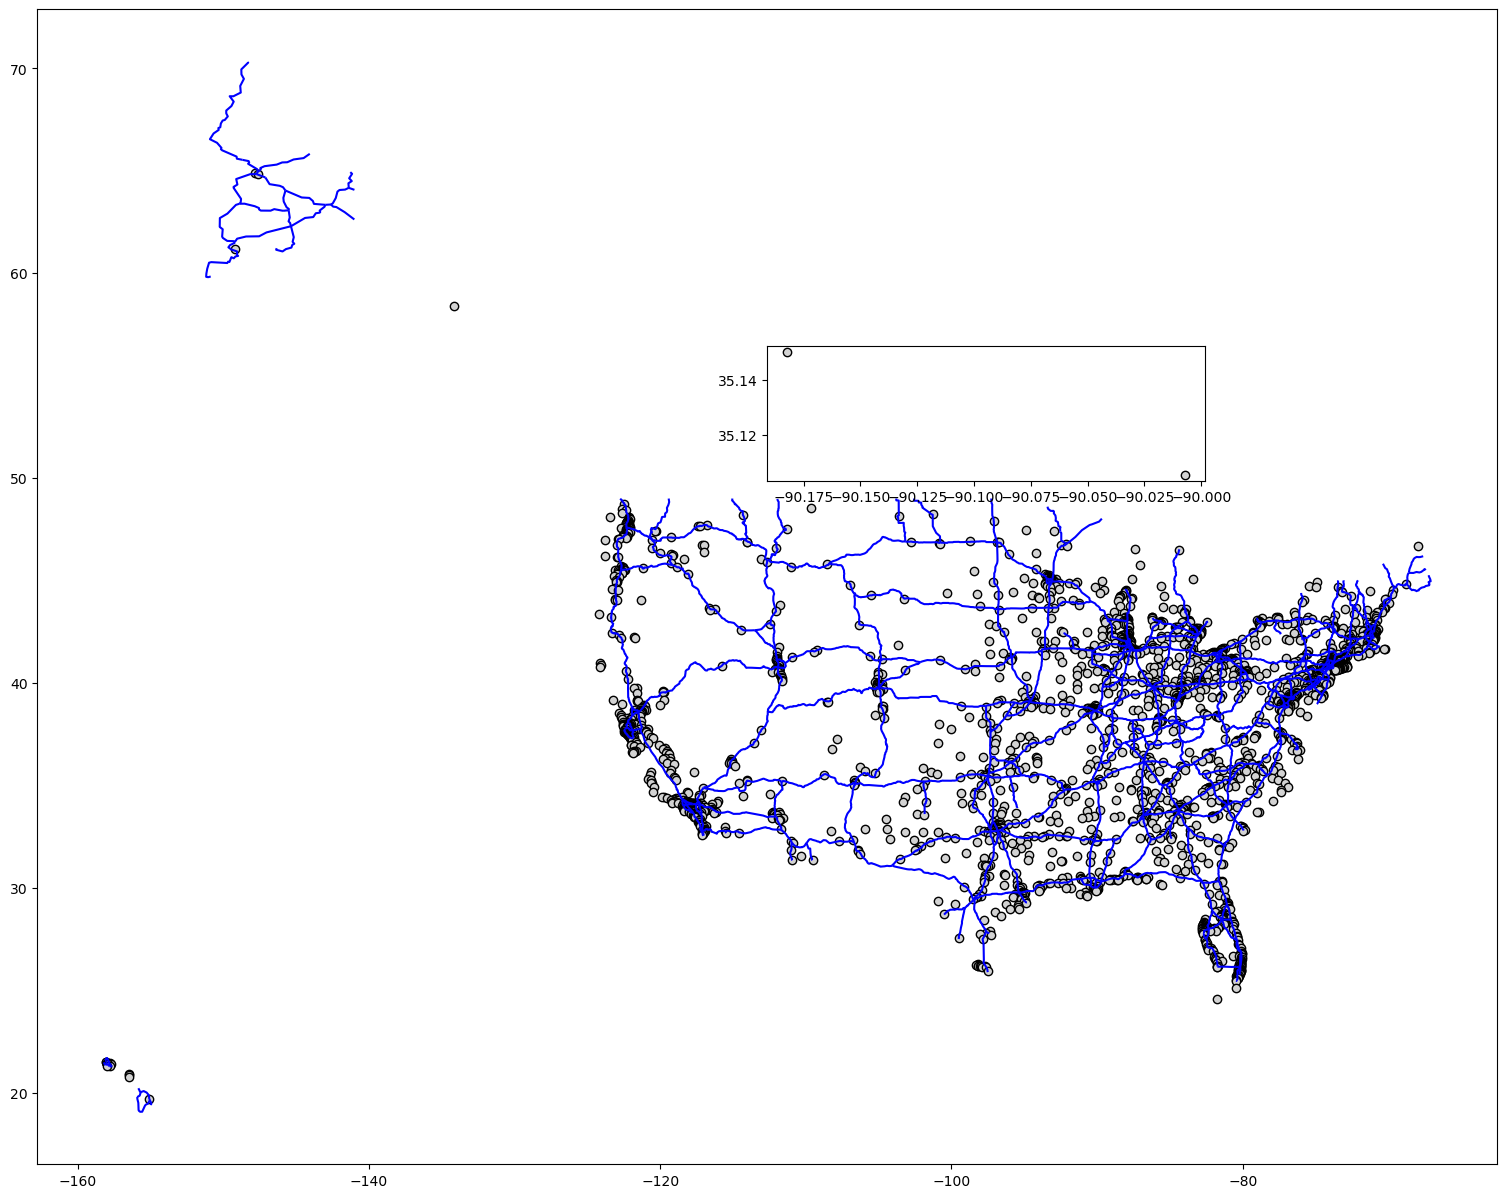

In [115]:
import geopandas as gpd  # For working with geospatial data
import os  # For file and directory management
import matplotlib.pyplot as plt  # For creating plots
import matplotlib.patches as mpatches  # For creating polygon legends
import matplotlib.lines as mlines  # For creating line and point legends

# Path to the folder containing the shapefiles
gdb_path = r'C:\Users\zmrplaza\OneDrive - The University of Memphis\Classes\Adv. GIS\Archivos\Oct24\USA'

# Function to list all shapefiles (.shp) in a directory and its subdirectories
def list_shapefiles(gdb_path):
    shapefiles = []
    for root, dirs, files in os.walk(gdb_path):  # Walk through all directories and files
        for file in files:  # Check each file
            if file.lower().endswith('.shp'):  # If the file is a shapefile, add it to the list
                shapefiles.append(os.path.join(root, file))  
    return shapefiles

# Function to let the user select shapefiles for plotting
def get_user_shapefile(shapefiles, prompt):
    while True:
        # Display the prompt and list all shapefiles
        print(prompt)
        for idx, shp in enumerate(shapefiles, start=1):
            print(f'{idx}: {os.path.basename(shp)}')  # Show the index and filename

        # Allow multiple shapefiles for the main plot
        if "main plot" in prompt: 
            choices = input("Enter the numbers of the shapefiles (comma-separated, e.g., 1,3,5): ")
            choices = [x.strip() for x in choices.split(",")]  # Split input into a list
            
            # Validate user input
            valid_choices = []
            for choice in choices:
                if choice.isdigit() and 1 <= int(choice) <= len(shapefiles):  # Check if input is valid
                    valid_choices.append(int(choice) - 1)  # Convert to index
                else:
                    print(f"Invalid choice: {choice}. Please enter valid numbers.")
                    break  # Exit loop if invalid input
            else:
                # Return the selected shapefiles as a list of paths
                return [shapefiles[choice] for choice in valid_choices]
        
        # Right now for the inset, this code allows only one shapefile
        else:
            choice = input("Enter the number of the shapefile: ")
            if choice.isdigit() and 1 <= int(choice) <= len(shapefiles):  # Check if the user's choice is a digit and within the valid range of shapefiles
                return shapefiles[int(choice) - 1]  # Return the selected shapefile path
            else:
                print(f"Invalid choice: {choice}. Please enter a valid number.")

# Function to filter a GeoDataFrame based on an attribute
def get_attribute_filter(gdf):
    while True:
        print("Available attributes:")  # Display available columns in the GeoDataFrame
        for idx, column in enumerate(gdf.columns, start=1):
            print(f'{idx}: {column}')  # Show index and column name
        
        # Prompt the user to enter the number corresponding to the attribute they want to filter by
        attr_choice = input("Enter the number of the attribute to filter by: ")
  
        # Check if the input is a digit and within the valid range of attribute indices
        if attr_choice.isdigit() and 1 <= int(attr_choice) <= len(gdf.columns):  # Validate input
            # Retrieve the name of the chosen attribute column based on user input
            attr_name = gdf.columns[int(attr_choice) - 1]  # Get the chosen column name

            # Display unique values in the chosen column
            unique_values = gdf[attr_name].unique()
            print(f"Unique values in '{attr_name}': {unique_values}")

            # Ask the user for a value to filter by
            attr_value = input(f"Enter the value to filter by in '{attr_name}': ")
            # Return a filtered GeoDataFrame based on the specified attribute value
            # The filtering checks if the attribute (attr_name) contains the given value (attr_value)
            # The search is case-insensitive and ignores NaN values
            return gdf[gdf[attr_name].str.contains(attr_value, case=False, na=False)]
        else:
            print(f"Invalid choice: {attr_choice}. Please enter a valid number.")

# Function to create a map with an inset
def create_inset_map(main_gdfs, inset_gdf, ax, inset_position=[0.5, 0.5, 0.3, 0.3]):
    # Create an inset axes on the main plot
    ax_inset = ax.inset_axes(inset_position)
    
    # Dictionary to store legend handles for different geometry types
    legend_handles = {
        'Polygon': [],
        'LineString': [],
        'Point': []
    }

    # Define colors for the layers
    colors = ['lightgray', 'blue', 'green', 'red', 'purple'] 
    for i, main_gdf in enumerate(main_gdfs):  # Loop through each main GeoDataFrame
        geom_type = main_gdf.geometry.geom_type.unique()[0]  # Get the geometry type
        
        # Plot on the main axes
        main_gdf.plot(ax=ax, color=colors[i % len(colors)], edgecolor='black', legend=True)
        
        # Clip the main GeoDataFrame with the inset GeoDataFrame
        clipped_main_gdf = gpd.clip(main_gdf, inset_gdf)  
        # Plot the clipped main GeoDataFrame on the inset map
        # Use the specified axis (ax_inset) for plotting
        # Set the color using a cyclic index based on the colors list
        # Use black for the edge color of the geometries
        clipped_main_gdf.plot(ax=ax_inset, color=colors[i % len(colors)], edgecolor='black')
        
        # Create legend entries based on geometry type
        # Check if the geometry type is 'Polygon'
        if geom_type == 'Polygon':
            # Create a patch for the polygon with the corresponding color and label
            patch = mpatches.Patch(color=colors[i % len(colors)], label=os.path.basename(main_shapefiles[i]).split('.')[0])
            # Append the patch to the legend handles for polygons
            legend_handles['Polygon'].append(patch)
        # Check if the geometry type is 'LineString'
        elif geom_type == 'LineString':
            # Create a line object for the line string with the corresponding color and label
            line = mlines.Line2D([], [], color=colors[i % len(colors)], label=os.path.basename(main_shapefiles[i]).split('.')[0])
            # Append the line object to the legend handles for line strings
            legend_handles['LineString'].append(line)
        # Check if the geometry type is 'Point'
        elif geom_type == 'Point':
            # Create a marker for the point with the corresponding color and label
            marker = mlines.Line2D([], [], color=colors[i % len(colors)], marker='o', linestyle='None', label=os.path.basename(main_shapefiles[i]).split('.')[0]) 
            # Append the marker to the legend handles for points
            legend_handles['Point'].append(marker)

        # Plot the inset GeoDataFrame
    inset_geom_type = inset_gdf.geometry.geom_type.unique()[0]  # Get the unique geometry type of the inset GeoDataFrame
    if inset_geom_type == 'Point':  # Check if the geometry type is 'Point'
        # Plot the points in the inset with a red color and specified marker size
        inset_gdf.plot(ax=ax_inset, color='red', markersize=50, label=os.path.basename(inset_shapefile).split('.')[0]) 
    else:
        # Plot other geometry types in the inset with a light blue color and black edges
        inset_gdf.plot(ax=ax_inset, color='lightblue', edgecolor='black', label=os.path.basename(inset_shapefile).split('.')[0])  

    # Remove ticks from the inset map
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

    # Add legend to the main plot
    legend_elements = []
    for geom_type, handles in legend_handles.items():
        if handles:  # Only add legend entries if there are handles
            legend_elements.extend(handles)
    
    ax.legend(handles=legend_elements, loc="lower right")

# Main execution

# List all shapefiles in the directory
shapefiles = list_shapefiles(gdb_path)

# Let the user select shapefiles for the main plot and inset
main_shapefiles = get_user_shapefile(shapefiles, "Select the shapefile(s) for the main plot:")
inset_shapefile = get_user_shapefile(shapefiles, "Select the shapefile for the inset:")

# Load the selected shapefiles into GeoDataFrames
main_gdfs = [gpd.read_file(shapefile) for shapefile in main_shapefiles]
inset_gdf = gpd.read_file(inset_shapefile)

# Apply attribute filtering to the inset GeoDataFrame
filtered_inset_gdf = get_attribute_filter(inset_gdf) 

# Create the main plot and inset map
fig, ax = plt.subplots(figsize=(20, 15))
create_inset_map(main_gdfs, filtered_inset_gdf, ax)  
plt.show()
